In [1]:
import sys
print(sys.executable)

/anaconda3/envs/magpie/bin/python


In [2]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers

%matplotlib inline
pd.options.display.max_columns = 999

Using TensorFlow backend.


In [3]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    
    return df

In [4]:
def load_df(csv_path='/Users/amitadate/WORK/MSAI/349_machine_learning/project_notebook/train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [5]:
train = load_df("train_v2.csv")
test = load_df("test_v2.csv")

Loaded train_v2.csv. Shape: (1708337, 60)
Loaded test_v2.csv. Shape: (401589, 59)


In [6]:
train_df = train.copy()
test_df = test.copy()

In [7]:

print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 1708337
Columns: 60
Features: ['channelGrouping' 'customDimensions' 'date' 'fullVisitorId' 'hits'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime'
 'device.browser' 'device.browserSize' 'device.browserVersion'
 'device.deviceCategory' 'device.flashVersion' 'device.isMobile'
 'device.language' 'device.mobileDeviceBranding' 'device.mobileDeviceInfo'
 'device.mobileDeviceMarketingName' 'device.mobileDeviceModel'
 'device.mobileInputSelector' 'device.operatingSystem'
 'device.operatingSystemVersion' 'device.screenColors'
 'device.screenResolution' 'geoNetwork.city' 'geoNetwork.cityId'
 'geoNetwork.continent' 'geoNetwork.country' 'geoNetwork.latitude'
 'geoNetwork.longitude' 'geoNetwork.metro' 'geoNetwork.networkDomain'
 'geoNetwork.networkLocation' 'geoNetwork.region'
 'geoNetwork.subContinent' 'totals.bounces' 'totals.hits'
 'totals.newVisits' 'totals.pageviews' 'totals.sessionQualityDim'
 'totals.timeOnSite' 'totals.totalTransactionRevenue'
 'totals.transa

In [8]:
train = add_time_features(train)
test = add_time_features(test)
# Convert target feature to 'float' type.
train['totals.transactionRevenue'] = train["totals.transactionRevenue"].astype('float')
train['totals.pageviews'] = train['totals.pageviews'].astype(float)
train['totals.hits'] = train['totals.hits'].astype(float)
test['totals.pageviews'] = test['totals.pageviews'].astype(float)
test['totals.transactionRevenue'] = test["totals.transactionRevenue"].astype('float')

In [9]:
test['totals.hits'] = test['totals.hits'].astype(float)

In [11]:
# Train
gp_fullVisitorId_train = train.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_train['fullVisitorId'] = gp_fullVisitorId_train.index
gp_fullVisitorId_train['mean_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.hits'].transform('mean')
gp_fullVisitorId_train['mean_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.pageviews'].transform('mean')
gp_fullVisitorId_train['sum_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.hits'].transform('sum')
gp_fullVisitorId_train['sum_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.pageviews'].transform('sum')
gp_fullVisitorId_train = gp_fullVisitorId_train[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
train = train.join(gp_fullVisitorId_train, on='fullVisitorId', how='inner', rsuffix='_')
train.drop(['fullVisitorId_'], axis=1, inplace=True)

# Test
gp_fullVisitorId_test = test.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_test['fullVisitorId'] = gp_fullVisitorId_test.index
gp_fullVisitorId_test['mean_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.hits'].transform('mean')
gp_fullVisitorId_test['mean_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.pageviews'].transform('mean')
gp_fullVisitorId_test['sum_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.hits'].transform('sum')
gp_fullVisitorId_test['sum_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.pageviews'].transform('sum')
gp_fullVisitorId_test = gp_fullVisitorId_test[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
test = test.join(gp_fullVisitorId_test, on='fullVisitorId', how='inner', rsuffix='_')
test.drop(['fullVisitorId_'], axis=1, inplace=True)

In [12]:
time_agg = train.groupby('date')['totals.transactionRevenue'].agg(['count', 'sum'])
year_agg = train.groupby('year')['totals.transactionRevenue'].agg(['sum'])
month_agg = train.groupby('month')['totals.transactionRevenue'].agg(['sum'])
day_agg = train.groupby('day')['totals.transactionRevenue'].agg(['sum'])
weekday_agg = train.groupby('weekday')['totals.transactionRevenue'].agg(['count','sum'])

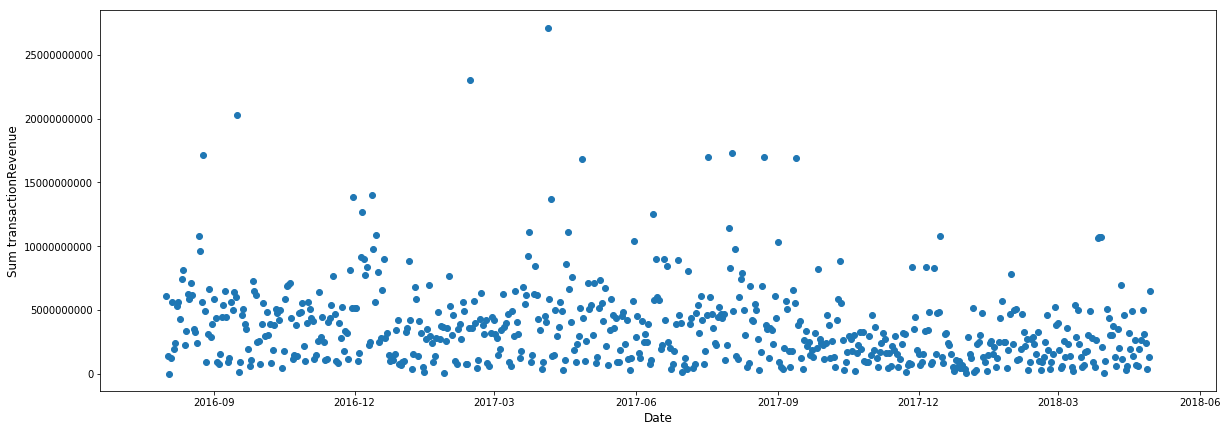

In [13]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Sum transactionRevenue', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['sum'])
plt.show()

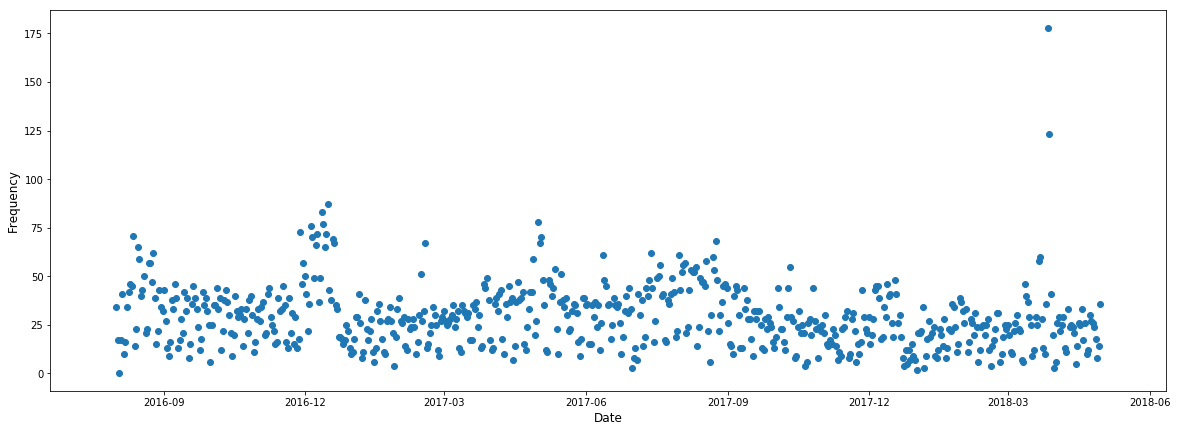

In [14]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['count'])
plt.show()

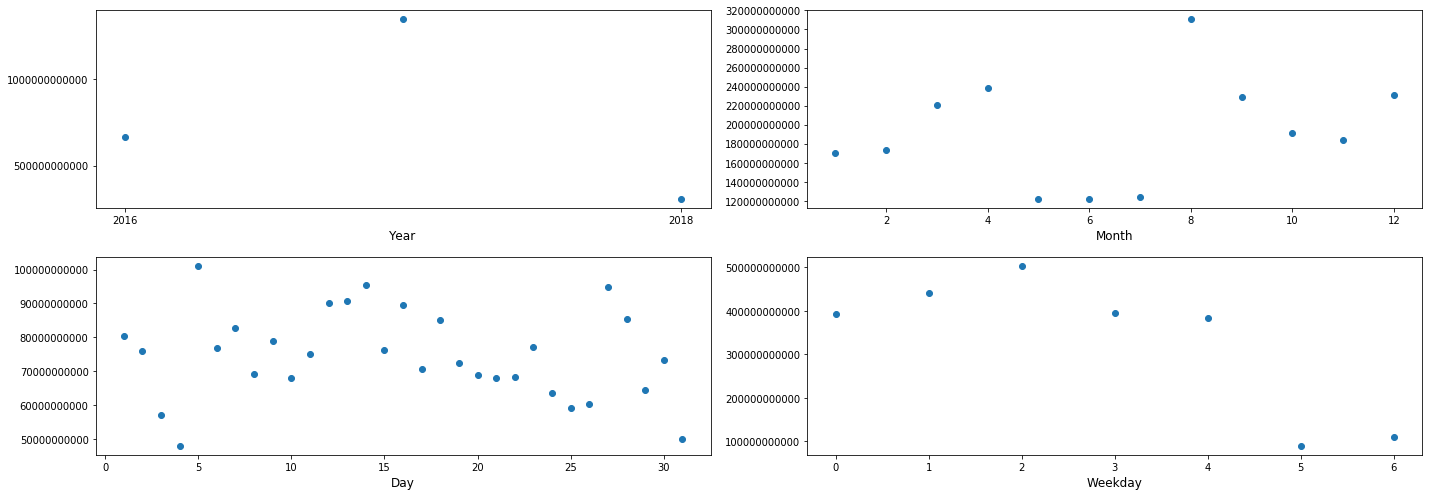

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,7))
ax1.scatter(year_agg.index.values, year_agg['sum'])
ax1.locator_params(nbins=2)
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xlabel('Year', fontsize=12)

ax2.scatter(month_agg.index.values, month_agg['sum'])
ax2.locator_params(nbins=12)
ax2.ticklabel_format(axis='y', style='plain')
ax2.set_xlabel('Month', fontsize=12)

ax3.scatter(day_agg.index.values, day_agg['sum'])
ax3.locator_params(nbins=10)
ax3.ticklabel_format(axis='y', style='plain')
ax3.set_xlabel('Day', fontsize=12)

ax4.scatter(weekday_agg.index.values, weekday_agg['sum'])
ax4.locator_params(nbins=7)
ax4.ticklabel_format(axis='y', style='plain')
ax4.set_xlabel('Weekday', fontsize=12)

plt.tight_layout()
plt.show()

In [16]:

train["totals.transactionRevenue"].fillna(0, inplace=True)

In [17]:
train

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,year,month,day,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day,mean_hits_per_day_,mean_pageviews_per_day_,sum_hits_per_day_,sum_pageviews_per_day_
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1.0,1,1.0,1,NaN,NaN,0.0,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google,2017,10,16,0,4.063883,3.455155,163616.0,139108.0,4.063883,3.455155,163616.0,139108.0
1,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2.0,NaN,2.0,2,28,NaN,0.0,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,2017,10,16,0,52.822785,42.227848,4173.0,3336.0,52.822785,42.227848,4173.0,3336.0
2868,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,1508160211,5,1508160211,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not avail

In [18]:
# dropiing the unwanted columns
unwanted_columns = ['customDimensions', 'day', 'hits']

In [19]:
train = train.drop(unwanted_columns, axis=1)
test = test.drop(unwanted_columns, axis=1)

In [20]:
constant_columns = [c for c in train.columns if train[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)

Columns with constant values:  ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.bounces', 'totals.newVisits', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.campaignCode', 'trafficSource.isTrueDirect']


In [21]:
train = train.drop(constant_columns, axis=1)

In [22]:
constant_columns = [c for c in test.columns if test[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)

Columns with constant values:  ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.bounces', 'totals.newVisits', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect', 'year']


In [23]:
test = test.drop(constant_columns, axis=1)

In [24]:
train = train.drop('year', axis=1)

In [25]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 1708337
Columns: 44
Features: ['channelGrouping' 'date' 'fullVisitorId' 'visitId' 'visitNumber'
 'visitStartTime' 'device.browser' 'device.deviceCategory'
 'device.isMobile' 'device.operatingSystem' 'geoNetwork.city'
 'geoNetwork.continent' 'geoNetwork.country' 'geoNetwork.metro'
 'geoNetwork.networkDomain' 'geoNetwork.region' 'geoNetwork.subContinent'
 'totals.hits' 'totals.pageviews' 'totals.sessionQualityDim'
 'totals.timeOnSite' 'totals.totalTransactionRevenue'
 'totals.transactionRevenue' 'totals.transactions'
 'trafficSource.adContent' 'trafficSource.adwordsClickInfo.adNetworkType'
 'trafficSource.adwordsClickInfo.gclId'
 'trafficSource.adwordsClickInfo.page'
 'trafficSource.adwordsClickInfo.slot' 'trafficSource.campaign'
 'trafficSource.keyword' 'trafficSource.medium'
 'trafficSource.referralPath' 'trafficSource.source' 'month' 'weekday'
 'mean_hits_per_day' 'mean_pageviews_per_day' 'sum_hits_per_day'
 'sum_pageviews_per_day' 'mean_hits_per_day_' 'mean_pageviews_

In [26]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,month,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day,mean_hits_per_day_,mean_pageviews_per_day_,sum_hits_per_day_,sum_pageviews_per_day_
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1.0,1.0,1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),water bottle,organic,NaN,google,10,0,4.063883,3.455155,163616.0,139108.0,4.063883,3.455155,163616.0,139108.0
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,2.0,2.0,2,28,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,10,0,52.822785,42.227848,4173.0,3336.0,52.822785,42.227848,4173.0,3336.0
2868,Referral,2017-10-16,8934116514970143966,1508160211,5,1508160211,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,2.0,2.0,2,15,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),/,(direct),10,0,52.822785,42.227848,4173.0,3336.0,52.822785,42.227848,4173.0,3336.0
7755,Referral,2017-11-30,8934116514970143966,1512072970,7,1512072970,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,3.0,3.0,2,43,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),/,(direct),11,3,52.822785,42.227848,4173.0,3336.0,52.822785,42.227848,4173.0,3336.0
422426,Referral,2017-09-22,8934116514970143966,1506112800,3,1506112800,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,2.0,2.0,2,41,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),/,(direct),9,4,52.822785,42.227848,4173.0,3336.0,52.822785,42.227848,4173.0,3336.0


In [27]:
categorical_features = ['device.isMobile', 'month', 'weekday']

In [28]:
train = pd.get_dummies(train, columns=categorical_features)
test = pd.get_dummies(test, columns=categorical_features)

In [29]:
train, test = train.align(test, join='outer', axis=1)

# replace the nan values added by align for 0
train.replace(to_replace=np.nan, value=0, inplace=True)
test.replace(to_replace=np.nan, value=0, inplace=True)

In [30]:
#creating test and validation set
X_train = train[train['date']<=datetime.date(2017, 12, 31)]
X_val = train[train['date']>datetime.date(2017, 12, 31)]

/anaconda3/envs/magpie/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
/anaconda3/envs/magpie/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
# Get labels
Y_train = X_train['totals.transactionRevenue'].values
Y_val = X_val['totals.transactionRevenue'].values
X_train = X_train.drop(['totals.transactionRevenue'], axis=1)
X_val = X_val.drop(['totals.transactionRevenue'], axis=1)
test = test.drop(['totals.transactionRevenue'], axis=1)


In [32]:
a = ['channelGrouping', 'date', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'fullVisitorId', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'totals.totalTransactionRevenue',
       'totals.transactions', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'visitId','visitStartTime']

In [33]:
reduce_features = a
X_train = X_train.drop(reduce_features, axis=1)
X_val = X_val.drop(reduce_features, axis=1)
test = test.drop(reduce_features, axis=1)


In [34]:
X_train.head()

,device.isMobile_False,device.isMobile_True,mean_hits_per_day,mean_hits_per_day_,mean_pageviews_per_day,mean_pageviews_per_day_,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,sum_hits_per_day,sum_hits_per_day_,sum_pageviews_per_day,sum_pageviews_per_day_,totals.hits,totals.pageviews,visitNumber,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,0,4.063883,4.063883,3.455155,3.455155,0,1,0,0,0,0,0,0,0,0,0,0,163616.0,163616.0,139108.0,139108.0,1.0,1.0,1,1,0,0,0,0,0,0
1,1,0,52.822785,52.822785,42.227848,42.227848,0,1,0,0,0,0,0,0,0,0,0,0,4173.0,4173.0,3336.0,3336.0,2.0,2.0,6,1,0,0,0,0,0,0
2868,1,0,52.822785,52.822785,42.227848,42.227848,0,1,0,0,0,0,0,0,0,0,0,0,4173.0,4173.0,3336.0,3336.0,2.0,2.0,5,1,0,0,0,0,0,0
7755,1,0,52.822785,52.822785,42.227848,42.227848,0,0,1,0,0,0,0,0,0,0,0,0,4173.0,4173.0,3336.0,3336.0,3.0,3.0,7,0,0,0,1,0,0,0
422426,1,0,52.822785,52.822785,42.227848,42.227848,0,0,0,0,0,0,0,0,0,0,0,1,4173.0,4173.0,3336.0,3336.0,2.0,2.0,3,0,0,0,0,1,0,0


In [35]:
normalized_features = ['visitNumber', 'totals.hits', 'totals.pageviews', 
                       'mean_hits_per_day', 'mean_pageviews_per_day', 
                       'sum_hits_per_day', 'sum_pageviews_per_day']

In [36]:
# Normalize using Min-Max scaling
scaler = preprocessing.MinMaxScaler()
X_train[normalized_features] = scaler.fit_transform(X_train[normalized_features])
X_val[normalized_features] = scaler.transform(X_val[normalized_features])
test[normalized_features] = scaler.transform(test[normalized_features])

In [37]:
X_train.head()

,device.isMobile_False,device.isMobile_True,mean_hits_per_day,mean_hits_per_day_,mean_pageviews_per_day,mean_pageviews_per_day_,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,sum_hits_per_day,sum_hits_per_day_,sum_pageviews_per_day,sum_pageviews_per_day_,totals.hits,totals.pageviews,visitNumber,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,0,0.000063,4.063883,0.000058,3.455155,0,1,0,0,0,0,0,0,0,0,0,0,0.899701,163616.0,0.903922,139108.0,0.000000,0.002,0.000000,1,0,0,0,0,0,0
1,1,0,0.005875,52.822785,0.005294,42.227848,0,1,0,0,0,0,0,0,0,0,0,0,0.022802,4173.0,0.021506,3336.0,0.002004,0.004,0.011962,1,0,0,0,0,0,0
2868,1,0,0.005875,52.822785,0.005294,42.227848,0,1,0,0,0,0,0,0,0,0,0,0,0.022802,4173.0,0.021506,3336.0,0.002004,0.004,0.009569,1,0,0,0,0,0,0
7755,1,0,0.005875,52.822785,0.005294,42.227848,0,0,1,0,0,0,0,0,0,0,0,0,0.022802,4173.0,0.021506,3336.0,0.004008,0.006,0.014354,0,0,0,1,0,0,0
422426,1,0,0.005875,52.822785,0.005294,42.227848,0,0,0,0,0,0,0,0,0,0,0,1,0.022802,4173.0,0.021506,3336.0,0.002004,0.004,0.004785,0,0,0,0,1,0,0


In [38]:
print(X_train.dtypes)

device.isMobile_False        uint8
device.isMobile_True         uint8
mean_hits_per_day          float64
mean_hits_per_day_         float64
mean_pageviews_per_day     float64
mean_pageviews_per_day_    float64
month_1                      uint8
month_10                     uint8
month_11                     uint8
month_12                     uint8
month_2                      uint8
month_3                      uint8
month_4                      uint8
month_5                      uint8
month_6                      uint8
month_7                      uint8
month_8                      uint8
month_9                      uint8
sum_hits_per_day           float64
sum_hits_per_day_          float64
sum_pageviews_per_day      float64
sum_pageviews_per_day_     float64
totals.hits                float64
totals.pageviews           float64
visitNumber                float64
weekday_0                    uint8
weekday_1                    uint8
weekday_2                    uint8
weekday_3           

In [48]:
Y_train = np.log1p(Y_train)
Y_val = np.log1p(Y_val)

In [50]:
Y_train.max()

23.86437469605166

In [ ]:
"""
Y_train
Y_val
X_train
X_val
""""""

In [ ]:
# model random forest

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt

x = X_train
y = Y_train


In [60]:
model = RandomForestRegressor(criterion='mse')
model.fit(x, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
predictions = model.predict(X_val)

In [62]:

ms = mean_squared_error(Y_val, predictions)

In [63]:

print(ms)


2.698554561523095


In [88]:
from math import sqrt

rms = sqrt(ms)

In [89]:
print(rms)

1.642727780712037


In [ ]:
# model for ada boost

In [93]:
from sklearn.ensemble import AdaBoostRegressor

In [99]:
model2 = AdaBoostRegressor(n_estimators=300)

In [100]:
model2.fit(X_train, Y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=300, random_state=None)

In [101]:
predictions2 = model2.predict(X_val)

In [102]:
ms2 = mean_squared_error(Y_val, predictions2)

In [103]:
print(ms2)

5.442843734297857


In [ ]:
# model for linear regression

In [108]:
from sklearn.linear_model import LinearRegression

In [109]:
model3 = LinearRegression()

In [118]:
model3.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [119]:
predictions3 = model3.predict(X_val)

In [120]:
ms3 = mean_squared_error(Y_val, predictions3)

In [129]:
print(ms3)

2.410731001020229


In [122]:
from math import sqrt
print(sqrt(ms3))

1.552652891350874


In [124]:
# model for decsision trees
from sklearn.tree import DecisionTreeRegressor

In [125]:
model4 = DecisionTreeRegressor()

In [128]:
model4.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [130]:
predictions4 = model4.predict(X_val)

In [131]:
ms4 = mean_squared_error(Y_val, predictions4)

In [132]:
print(ms4)

4.582532877107545


In [44]:
# MODEL DEEP LEARNING 

In [133]:
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.0003

In [134]:
model = Sequential()
model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

In [135]:
adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)

In [136]:
print('Dataset size: %s' % X_train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % X_train.shape[1])
print('Features used: %s' % X_train.columns.values)

Dataset size: 1365253
Epochs: 50
Learning rate: 0.0003
Batch size: 128
Input dimension: 32
Features used: ['device.isMobile_False' 'device.isMobile_True' 'mean_hits_per_day'
 'mean_hits_per_day_' 'mean_pageviews_per_day' 'mean_pageviews_per_day_'
 'month_1' 'month_10' 'month_11' 'month_12' 'month_2' 'month_3' 'month_4'
 'month_5' 'month_6' 'month_7' 'month_8' 'month_9' 'sum_hits_per_day'
 'sum_hits_per_day_' 'sum_pageviews_per_day' 'sum_pageviews_per_day_'
 'totals.hits' 'totals.pageviews' 'visitNumber' 'weekday_0' 'weekday_1'
 'weekday_2' 'weekday_3' 'weekday_4' 'weekday_5' 'weekday_6']


In [137]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 41,473
Trainable params: 41,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x=X_train.values, y=Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(X_val.values, Y_val))

Train on 1365253 samples, validate on 343084 samples
Epoch 1/50


In [1]:
train.head()

NameError: name 'train' is not defined